# Apple Stock Data Project
This project is put together by evaluating APPL stock data through yahoo finance API. We are looking into 1 year of historical data at 1 hour intervals. The following are goals of this project:
 1) Build a model that can accurately predict rise or fall of a selected stock
 2) Make it easy to follow and interact. We would like this to be automated so anyone can use this to check any stock data.
 3) Build as accurate of model as possible while retaining as many variables. 

## Data Collection and Preparation

### Stock price data
We used the yahoo finance API to obtain data of the AAPL stock. No outliers were present in the data, as Apple’s stock prices were generally non-volatile in recent history.

### Technical analysis indicators
We took the raw stock data and transformed it by creating TA indicators (using the numpy ta package).  We used TA indicators because they're a tried and true method to track and predict price movement. TA indicators make up the majority of our variables.

### Economic indicators and Financial Statements
We considered using multiple economic indicators for the project such as GDP. However, most economic indicators are not reported at the same time granularity as our project (hrs). We’ve included the interest rates as a variable.

We reviewed financial statements and quarterly filings. We determined they were ultimately only relevant for impacting prices and volume quarterly. The only thing financial statements appear to do is cause trade volume to spike prior to release (ex: 2/29/24 – trading volume ~ tripled from 49 mil – 136 mil, price went down from $181 – $180, with a low of $179. Investors appear to somehow make up their minds about Apple's financials before Apple, inc even released anything. This implied that sentiment analysis building up to the release date is more relevant than the statements they release). 

### Analyst Sentiment Analysis
Sentiment analysis was determined to be more important. 
An example: [Apple's sales slumped for 5 consecutive quarters](https://apnews.com/article/apple-iphone-quarterly-sales-slump-e9bf22e92a70ea8e84f39fa5189aabb1), but due to apple planning to enact a stock buyback, the price surged. Prices then continued to go up due to this being [a record-breaking buyback for AAPL.](https://www.investopedia.com/apple-beat-its-own-record-with-blockbuster-buyback-plan-8643249) Paying attention to the news instead of reviewing financial statements might be a more effective strategy.

A news article text analysis using an RSS reader python package was briefly considered, but we came up with a better idea: **analyze the sentiment of the stock analysts.** This would be faster and more efficient than checking the news for positive/negative words. Institutional analysts have an impact on the market sentiment, but they also appear to simultaneously work as a litmus test for market confidence. This means we can outsource some of our ML project's computing power to computers with higher critical thinking skills: human brains. 
Analyst ratings are obtained through the yahoo finance API, stored in variables, and used to create ratios.

## Sentiment Analysis variables (analyst ratings and ratios)

### Description

Gets analyst ratings of AAPL and makes variables from them. Also creates new ratios from the analyst ratings.

If the denominator variable of any ratio is 0, it sets the ratio value to 10 instead of infinity (so as to still capture the high disparity of the two variables). If both numerator and denominator are 0: sets the ratio value to 0 instead of erroring out.

---
The **ratio variables** will likely be more useful than the individual variables because they provide context for the analyst ratings. What percent of analysts are recommending to buy, to hold, or to sell? Without context, you just have a number.
 
Ex: if there is a high amount of buy ratings and a low amount of sell variables, this indicates the market is very confident. If the hold ratings equal out, this may indicate some future sideways movement of the stock price.
If the buy ratings go down, and hold ratings go up, the confidence is cooling down, but still positive.
If the sell ratings continue to crop up, it indicates uncertainty, whatever the reason. The price may go down in the future, or may be in the process of going down.


## Interest Variables

In [1]:
import requests
import pandas as pd

# Your FRED API key
api_key = '09ce1a4fee75646eab3716866a4b3c5a'

# Define the date range
start_date = '2023-07-25'
end_date = '2024-07-25'

# Define a list of relevant FRED series IDs including interest rates
series_ids = ['DPRIME']      # Prime Rate


# Function to fetch data from FRED API
def fetch_fred_data(series_id, start_date, end_date, api_key):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date,
    }
    response = requests.get(url, params=params)
    data = response.json()
    return data

# Create an empty DataFrame to store data
df_all_data = pd.DataFrame()

# Fetch data for each series and store in DataFrame
for series_id in series_ids:
    try:
        data = fetch_fred_data(series_id, start_date, end_date, api_key)
        observations = data['observations']
        df_series = pd.DataFrame(observations)[['date', 'value']]
        df_series.set_index('date', inplace=True)
        df_series.columns = [series_id]
        df_all_data = pd.concat([df_all_data, df_series], axis=1)
    except Exception as e:
        print(f"Error fetching data for series {series_id}: {e}")

# Remove rows with all NaN values
df_all_data.dropna(how='all', inplace=True)

# Save data to Excel
file_name = 'FRED_indicators.xlsx'
df_all_data.to_excel(file_name)
interest_rate = df_all_data
print(f"Data downloaded and exported to {file_name}")


Data downloaded and exported to FRED_indicators.xlsx


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from ta import add_all_ta_features
import seaborn as sns

def get_stock_data(ticker, period='1y', interval='1h'):
    # Fetch historical data
    stock_data = yf.download(ticker, period=period, interval=interval)

    # Check if data is fetched successfully
    if stock_data.empty:
        print(f"Failed to fetch data for ticker: {ticker}")
        return stock_data
    
    # Convert datetime index to be timezone-unaware
    stock_data.index = stock_data.index.tz_localize(None)

    # Sort data by index
    stock_data = stock_data.sort_index()

    # Add comprehensive technical indicators using pandas-ta
    comprehensive_strategy = ta.Strategy(
        name="Comprehensive Strategy with Variations",
        ta=[
            # Simple Moving Average (SMA)
            {"kind": "sma", "length": length} for length in range(10, 500, 5)
        ] + [
            # Exponential Moving Average (EMA)
            {"kind": "ema", "length": length} for length in range(10, 500, 5)
        ] + [
            # Relative Strength Index (RSI)
            {"kind": "rsi", "length": length} for length in range(10, 300, 5)
        ] + [
            # MACD with various configurations
            {"kind": "macd", "fast": fast, "slow": slow, "signal": signal} 
            for fast, slow, signal in [(12, 26, 9), (6, 13, 5), (19, 39, 9)]
        ] + [
            # Stochastic Oscillator
            {"kind": "stoch", "fastk": k, "slowk": slowk, "slowd": slowd}
            for k, slowk, slowd in [(14, 3, 3), (14, 5, 5), (14, 7, 7)]
        ] + [
            # Bollinger Bands
            {"kind": "bbands", "length": length, "std": std} 
            for length in range(20, 30, 5) for std in range(2, 4)
        ] + [
            # Average True Range (ATR)
            {"kind": "atr", "length": length} for length in range(14, 300, 5)
        ] + [
            # Money Flow Index (MFI)
            {"kind": "mfi", "length": length} for length in range(14, 300, 5)
        ] + [
            # Commodity Channel Index (CCI)
            {"kind": "cci", "length": length} for length in range(20, 300, 5)
        ]
    )

    # Apply the comprehensive strategy to the stock data
    stock_data.ta.strategy(comprehensive_strategy)

    # Add additional TA indicators using ta library
    stock_data = add_all_ta_features(
        stock_data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
    )
    
    # Ensure the column names are in lowercase
    stock_data.columns = [col.lower() for col in stock_data.columns]
    
    # Add categorical indicators
    if 'sma_50' in stock_data.columns and 'sma_200' in stock_data.columns:
        stock_data['trend'] = stock_data.apply(
            lambda x: 'Uptrend' if x['sma_50'] > x['sma_200'] else ('Downtrend' if x['sma_50'] < x['sma_200'] else 'Sideways'), 
            axis=1
        )
    else:
        stock_data['trend'] = 'N/A'
    
    if 'rsi_14' in stock_data.columns:
        stock_data['momentum'] = stock_data['rsi_14'].apply(
            lambda x: 'Strong' if x > 70 else ('Weak' if x < 30 else 'Neutral')
        )
    else:
        stock_data['momentum'] = 'N/A'

    if 'macd_12_26_9' in stock_data.columns and 'macd_12_26_9_signal' in stock_data.columns:
        stock_data['signal'] = stock_data.apply(
            lambda x: 'Buy' if x['macd_12_26_9'] > x['macd_12_26_9_signal'] else ('Sell' if x['macd_12_26_9'] < x['macd_12_26_9_signal'] else 'Hold'), 
            axis=1
        )
    else:
        stock_data['signal'] = 'N/A'
    
    # Convert index to a column for saving to Excel
    stock_data = stock_data.reset_index()
    
    return stock_data

import os

def save_to_excel(df, filename):
    # Check if the file already exists
    if not os.path.exists(filename):
        # Save the DataFrame to an Excel file
        df.to_excel(filename, index=False, engine='openpyxl')
        print(f"Data saved to {filename}")
    else:
        print(f"{filename} already exists. Skipping save.")

def process_tickers(tickers, period='1y', interval='1h'):
    # Dictionary to hold DataFrames
    data_frames = {}

    # Loop through each ticker symbol
    for ticker in tickers:
        data = get_stock_data(ticker, period, interval)
        if not data.empty:
            data_frames[ticker] = data
            save_to_excel(data, f'{ticker}_with_indicators.xlsx')
    
    return data_frames


def combine_data(aapl_data, other_data_frames):
    combined_data = aapl_data.copy()
    for ticker, df in other_data_frames.items():
        # Take columns 1-6 and rename them
        new_columns = {col: f"{ticker}_{col}" for col in df.columns[:6]}
        df = df.iloc[:, :6].rename(columns=new_columns)
        combined_data = pd.concat([combined_data, df], axis=1)
    return combined_data

# Example usage
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
data_frames = process_tickers(tickers)

# Separate AAPL data
AAPL = data_frames.pop('AAPL')
MSFT_data = data_frames.pop('MSFT')
GOOGL_data = data_frames.pop('GOOGL')
AMZN_data = data_frames.pop('AMZN')

# Combine data
AAPL_data = combine_data(AAPL, data_frames)

# Save the combined data
save_to_excel(AAPL_data, 'AAPL_combined_with_indicators.xlsx')

[*********************100%%**********************]  1 of 1 completed


AAPL_with_indicators.xlsx already exists. Skipping save.


[*********************100%%**********************]  1 of 1 completed


MSFT_with_indicators.xlsx already exists. Skipping save.


[*********************100%%**********************]  1 of 1 completed


GOOGL_with_indicators.xlsx already exists. Skipping save.


[*********************100%%**********************]  1 of 1 completed


AMZN_with_indicators.xlsx already exists. Skipping save.
AAPL_combined_with_indicators.xlsx already exists. Skipping save.


In [3]:
AAPL_data.tail()

,Datetime,open,high,low,close,adj close,volume,sma_10,sma_15,sma_20,...,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,trend,momentum,signal
1739,2024-08-02 13:30:00,224.630005,225.005005,221.910004,223.434998,223.434998,7549443,220.977498,221.208338,221.393504,...,19.096435,17.886015,1.210420,220.033869,-0.536415,-0.537859,24.799616,Downtrend,N/A,N/A
1740,2024-08-02 14:30:00,223.419998,224.100006,222.110001,222.619995,222.619995,6527167,221.307497,221.187672,221.585004,...,14.993846,17.307581,-2.313735,220.202800,-0.364760,-0.365427,24.344397,Downtrend,N/A,N/A
1741,2024-08-02 15:30:00,222.630005,222.988297,219.059998,219.800003,219.800003,11042774,221.472498,221.066998,221.433504,...,15.571728,16.960410,-1.388682,220.194100,-1.266729,-1.274820,22.769290,Downtrend,N/A,N/A
1742,2024-08-05 09:30:00,199.000000,211.110001,198.229996,207.978699,207.978699,43357359,220.491368,220.132911,220.674689,...,36.474704,20.863269,15.611435,218.975907,-5.378209,-5.528239,16.166501,Downtrend,N/A,N/A
1743,2024-08-05 10:30:00,207.940704,210.399994,207.820007,209.270004,209.270004,5637633,219.612869,219.332245,220.019689,...,28.096091,22.309833,5.786257,218.214427,0.620884,0.618964,16.887759,Downtrend,N/A,N/A


The following code downloads stock data for specified ticker symbols over a defined time period and interval. By default, it retrieves data for 1 year at 1-hour intervals. For this analysis, we include top competitors to Apple, such as Microsoft, Google, and Amazon. We use their values for the open, close, high, low, and volume columns to aid in our predictions.

Although we focus on Apple data for this project to simplify the analysis, we save the Excel files for the other tickers for future reference. Additionally, we download an Excel file with FRED indicators, which includes variables like interest rates and unemployment rates for the specified time period.

## Stage 2.A Data Quality Check
In this stage we will be filtering through our data and revealing useful infromation about our data. This will include data types, variable information, sample values of the varables we will use. We will also show statistics related to numeric and categorical columns. Below is the name and description of some of the varialbes present in the data. 

| Name                     | Description                            |
|--------------------------|----------------------------------------|
| Datetime                 | Date and time of the data point         |
| open                     | Opening price                          |
| high                     | Highest price during the period         |
| low                      | Lowest price during the period          |
| close                    | Closing price                          |
| adj close                | Adjusted closing price                 |
| volume                   | Trading volume                         |
| sma_50                   | Simple Moving Average (50 periods)      |
| sma_100                  | Simple Moving Average (100 periods)     |
| sma_200                  | Simple Moving Average (200 periods)     |
| ema_50                   | Exponential Moving Average (50 periods) |
| ema_100                  | Exponential Moving Average (100 periods)|
| ema_200                  | Exponential Moving Average (200 periods)|
| macd                     | Moving Average Convergence Divergence  |
| macd_signal              | MACD Signal Line                       |
| macd_diff                | MACD Histogram                         |
| adx                      | Average Directional Index              |
| adx_pos                  | ADX Positive Directional Movement      |
| adx_neg                  | ADX Negative Directional Movement      |
| cci                      | Commodity Channel Index                |
| trix                     | Triple Exponential Moving Average      |
| ema_12                   | Exponential Moving Average (12 periods) |
| ema_26                   | Exponential Moving Average (26 periods) |
| wma_20                   | Weighted Moving Average (20 periods)   |
| sma_10                   | Simple Moving Average (10 periods)     |
| sma_30                   | Simple Moving Average (30 periods)     |
| ema_10                   | Exponential Moving Average (10 periods) |
| ema_20                   | Exponential Moving Average (20 periods) |
| rsi_14                   | Relative Strength Index (14 periods)   |
| rsi_30                   | Relative Strength Index (30 periods)   |
| stoch                    | Stochastic Oscillator                  |
| stoch_signal             | Stochastic Signal Line                 |
| williams_r               | Williams %R                            |
| stoch_rsi                | Stochastic RSI                         |
| stoch_rsi_signal         | Stochastic RSI Signal Line             |
| roc                      | Rate of Change                         |
| mfi                      | Money Flow Index                       |
| mfi_30                   | Money Flow Index (30 periods)          |
| cmf                      | Chaikin Money Flow                     |
| adi                      | Accumulation/Distribution Indicator    |
| vwap                     | Volume Weighted Average Price          |
| bollinger_hband          | Bollinger Bands: High Band             |
| bollinger_lband          | Bollinger Bands: Low Band              |
| bollinger_mavg           | Bollinger Bands: Moving Average        |
| bollinger_pband          | Bollinger Bands: %B                    |
| bollinger_wband          | Bollinger Bands: Width                 |
| atr                      | Average True Range                     |
| bollinger_hband_indicator| Bollinger Bands: High Band Indicator   |
| bollinger_lband_indicator| Bollinger Bands: Low Band Indicator    |



Analyzing column: 'ema_450'

Analyzing numeric column 'ema_450':
Data type: float64
Number of Observations: 1744
Range: 34.28
Min: 174.69, Max: 208.97
Mean: 185.15
Standard Deviation: 8.09
Variance: 65.47
Mode: 174.69
Median: 184.2
25% Quartile: 179.2
50% Quartile (Median): 184.2
75% Quartile: 187.49
95% Quartile: 205.37


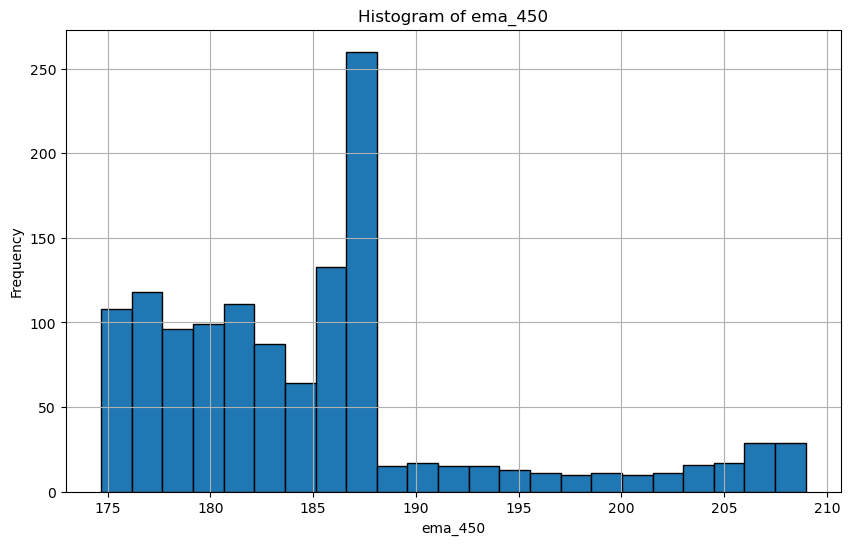


Analyzing column: 'rsi_235'

Analyzing numeric column 'rsi_235':
Data type: float64
Number of Observations: 1744
Range: 17.01
Min: 44.32, Max: 61.33
Mean: 51.43
Standard Deviation: 3.77
Variance: 14.2
Mode: 52.2
Median: 51.01
25% Quartile: 48.16
50% Quartile (Median): 51.01
75% Quartile: 54.31
95% Quartile: 58.35


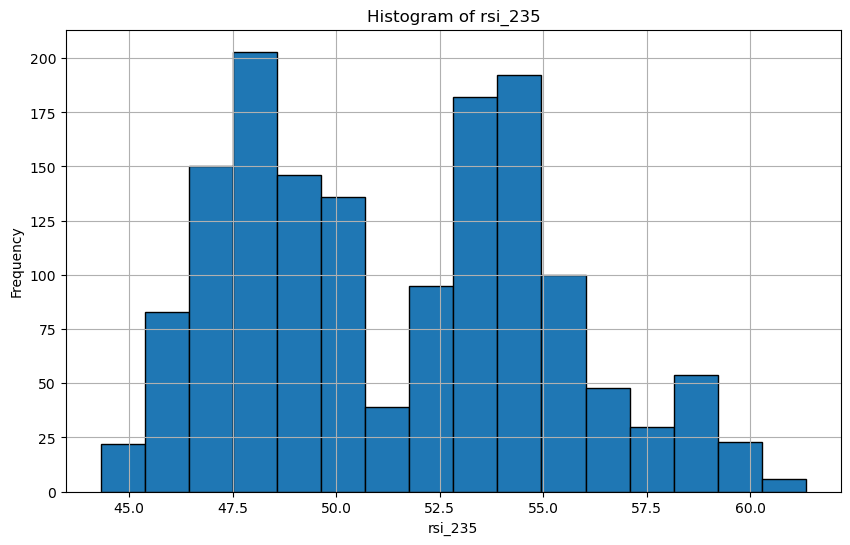


Analyzing column: 'sma_35'

Analyzing numeric column 'sma_35':
Data type: float64
Number of Observations: 1744
Range: 65.33
Min: 166.62, Max: 231.95
Mean: 186.9
Standard Deviation: 15.63
Variance: 244.21
Mode: 166.62
Median: 183.75
25% Quartile: 175.35
50% Quartile (Median): 183.75
75% Quartile: 192.14
95% Quartile: 222.5


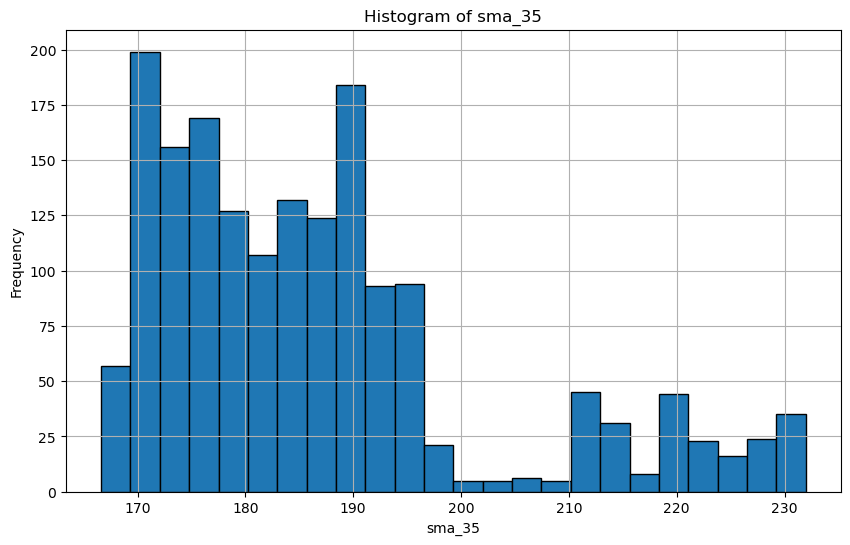


Analyzing column: 'sma_435'

Analyzing numeric column 'sma_435':
Data type: float64
Number of Observations: 1744
Range: 33.01
Min: 174.52, Max: 207.53
Mean: 183.85
Standard Deviation: 7.28
Variance: 53.0
Mode: 174.52
Median: 182.8
25% Quartile: 178.17
50% Quartile (Median): 182.8
75% Quartile: 188.19
95% Quartile: 200.2


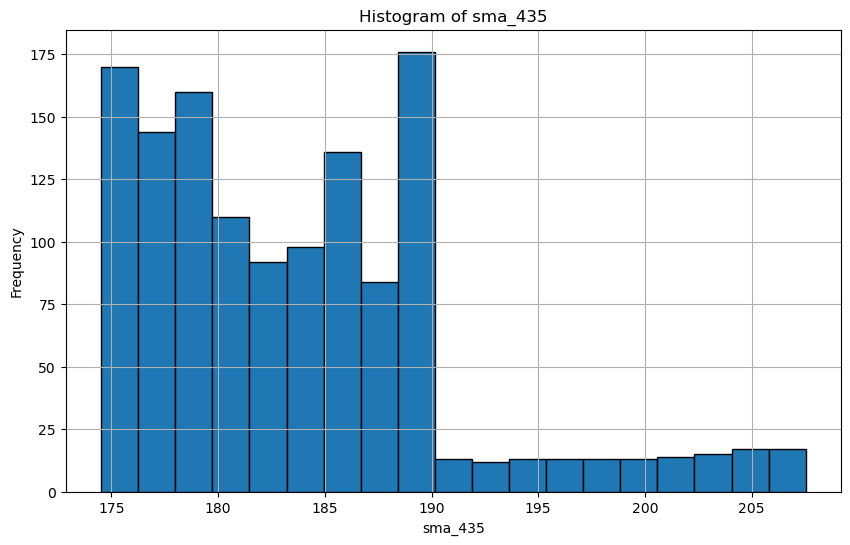


Analyzing column: 'sma_265'

Analyzing numeric column 'sma_265':
Data type: float64
Number of Observations: 1744
Range: 48.34
Min: 170.78, Max: 219.12
Mean: 184.76
Standard Deviation: 11.07
Variance: 122.5
Mode: 170.78
Median: 182.23
25% Quartile: 176.73
50% Quartile (Median): 182.23
75% Quartile: 190.4
95% Quartile: 211.37


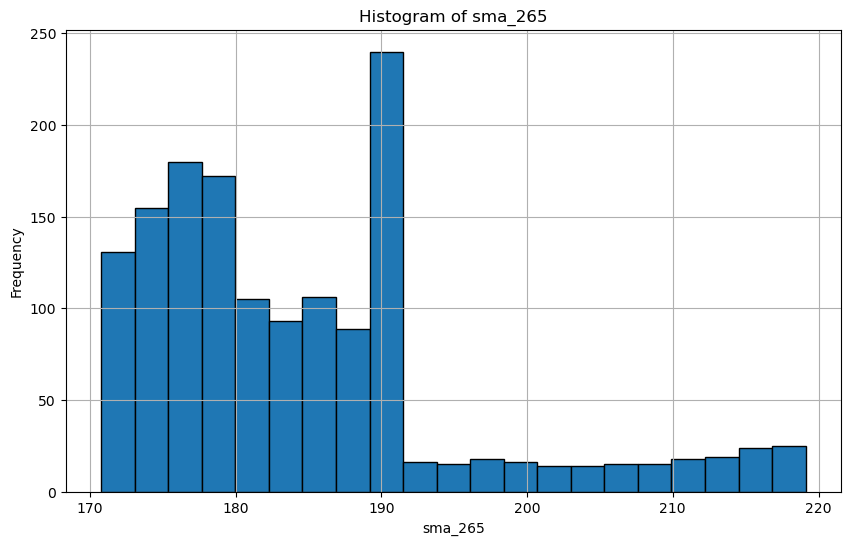


Analyzing column: 'trend'

Analyzing categorical column 'trend':
Data type: object

Frequency Table:
       trend  Frequency  Percent Frequency  Cumulative Frequency  \
0    Uptrend        802              45.99                   802   
1  Downtrend        743              42.60                  1545   
2   Sideways        199              11.41                  1744   

   Cumulative Percent Frequency  
0                         45.99  
1                         88.59  
2                        100.00  
Mode: Uptrend with frequency 802
Lowest Frequency: Sideways with frequency 199


<Figure size 1000x600 with 0 Axes>

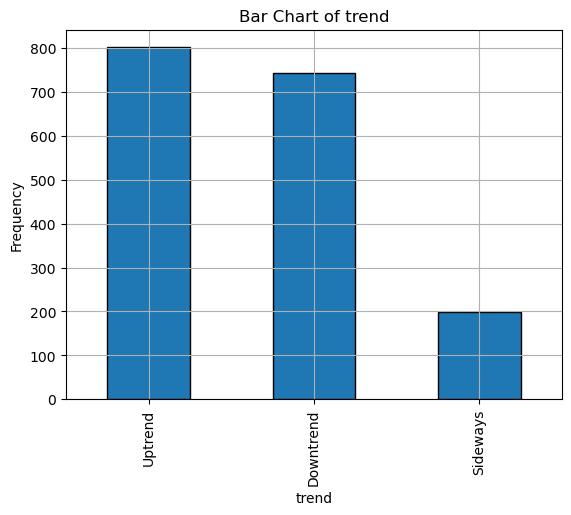


Findings for 'trend':
The bar chart shows the frequency distribution of categories. Look for dominant categories and any potential imbalance.
Analyze the mode to identify the most common category and the lowest frequency to find rare categories.

Analyzing column: 'momentum'

Analyzing categorical column 'momentum':
Data type: object

Frequency Table:
  momentum  Frequency  Percent Frequency  Cumulative Frequency  \
0      N/A       1744              100.0                  1744   

   Cumulative Percent Frequency  
0                         100.0  
Mode: N/A with frequency 1744
Lowest Frequency: N/A with frequency 1744


<Figure size 1000x600 with 0 Axes>

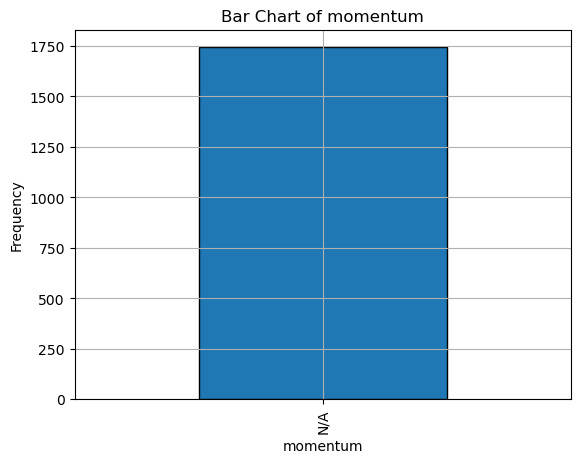


Findings for 'momentum':
The bar chart shows the frequency distribution of categories. Look for dominant categories and any potential imbalance.
Analyze the mode to identify the most common category and the lowest frequency to find rare categories.

Analyzing column: 'signal'

Analyzing categorical column 'signal':
Data type: object

Frequency Table:
  signal  Frequency  Percent Frequency  Cumulative Frequency  \
0    N/A       1744              100.0                  1744   

   Cumulative Percent Frequency  
0                         100.0  
Mode: N/A with frequency 1744
Lowest Frequency: N/A with frequency 1744


<Figure size 1000x600 with 0 Axes>

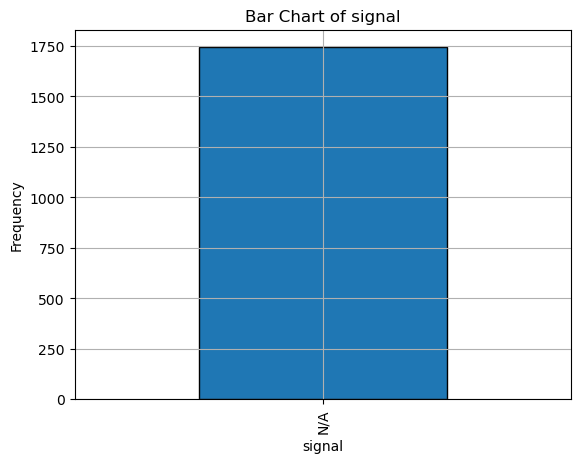


Findings for 'signal':
The bar chart shows the frequency distribution of categories. Look for dominant categories and any potential imbalance.
Analyze the mode to identify the most common category and the lowest frequency to find rare categories.


In [4]:

def analyze_columns(df):
    np.random.seed(1234)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=[object]).columns.tolist()
    
    if len(numeric_cols) > 5:
        numeric_cols = np.random.choice(numeric_cols, 5, replace=False)
    
    if len(categorical_cols) > 5:
        categorical_cols = np.random.choice(categorical_cols, 2, replace=False)
    
    columns_to_analyze = list(numeric_cols) + list(categorical_cols)
    
    for column in columns_to_analyze:
        # Print the column name
        print(f"\nAnalyzing column: '{column}'")
        
        # Get the column data
        column_data = df[column]

        # Determine the type of the column
        if pd.api.types.is_numeric_dtype(column_data):
            # Numeric Column Analysis
            print(f"\nAnalyzing numeric column '{column}':")
            print(f"Data type: {column_data.dtype}")

            # a. Number of observations
            num_observations = len(column_data)
            print(f"Number of Observations: {num_observations}")

            # b. Range of the variable
            data_range = round(column_data.max() - column_data.min(), 2)
            print(f"Range: {data_range}")

            # c. Min and Max of the variable
            min_value = round(column_data.min(), 2)
            max_value = round(column_data.max(), 2)
            print(f"Min: {min_value}, Max: {max_value}")

            # d. Mean, Standard Deviation, and Variance
            mean_value = round(column_data.mean(), 2)
            std_dev = round(column_data.std(), 2)
            variance = round(column_data.var(), 2)
            print(f"Mean: {mean_value}")
            print(f"Standard Deviation: {std_dev}")
            print(f"Variance: {variance}")

            # e. Mode, Median, Quartiles (25%, 50%, 75%, 95%)
            mode_value = round(column_data.mode().iloc[0], 2) if not column_data.mode().empty else 'N/A'
            median_value = round(column_data.median(), 2)
            q25 = round(column_data.quantile(0.25), 2)
            q50 = round(column_data.quantile(0.50), 2)
            q75 = round(column_data.quantile(0.75), 2)
            q95 = round(column_data.quantile(0.95), 2)
            print(f"Mode: {mode_value}")
            print(f"Median: {median_value}")
            print(f"25% Quartile: {q25}")
            print(f"50% Quartile (Median): {q50}")
            print(f"75% Quartile: {q75}")
            print(f"95% Quartile: {q95}")

            # f. Histogram of the variable
            plt.figure(figsize=(10, 6))
            plt.hist(column_data, bins='auto', edgecolor='black')
            plt.title(f'Histogram of {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()
        
        elif pd.api.types.is_object_dtype(column_data):
            # Categorical Column Analysis
            print(f"\nAnalyzing categorical column '{column}':")
            print(f"Data type: {column_data.dtype}")

            # a. Frequency table
            freq_table = column_data.value_counts().reset_index()
            freq_table.columns = [column, 'Frequency']
            freq_table['Percent Frequency'] = round((freq_table['Frequency'] / len(column_data)) * 100, 2)
            freq_table['Cumulative Frequency'] = freq_table['Frequency'].cumsum()
            freq_table['Cumulative Percent Frequency'] = round(freq_table['Cumulative Frequency'] / len(column_data) * 100, 2)
            print("\nFrequency Table:")
            print(freq_table)

            # b. Mode (highest frequency) and Lowest Frequency
            mode = freq_table.iloc[0]
            min_freq = freq_table.iloc[-1]
            print(f"Mode: {mode[column]} with frequency {mode['Frequency']}")
            print(f"Lowest Frequency: {min_freq[column]} with frequency {min_freq['Frequency']}")

            # c. Bar Chart of the variable
            plt.figure(figsize=(10, 6))
            freq_table.plot(kind='bar', x=column, y='Frequency', legend=False, edgecolor='black')
            plt.title(f'Bar Chart of {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()

            # d. Findings
            # Example findings based on statistics
            print(f"\nFindings for '{column}':")
            print(f"The bar chart shows the frequency distribution of categories. Look for dominant categories and any potential imbalance.")
            print(f"Analyze the mode to identify the most common category and the lowest frequency to find rare categories.")
        else:
            print(f"Column '{column}' is neither numeric nor categorical and is skipped.")


# Analyze selected columns
analyze_columns(AAPL_data)

The graphs all seem to show that AAPL price spend most of its time relatively neutral and non-volatile, which means it should be easy for our model to predict. However, we should keep these small changes in these variables in mind as we tweak the model. The model should be attuned to detect these relatively small changes, and adapt appropriately.
 
The RSI histogram (Relative Strength Index) shows that - at least for the period of time graphed - AAPL spends most of its time relatively neutral (floats mostly around the 50 point mark). Not extremely oversold or overbought (never below 30 or above 70, respectively). The model should be attuned to detect relatively small changes in RSI as possible changes in market sentiment.
 
The SMA and EMA charts have similar general trends, but EMA is less stratified.
Why are we using both SMA and EMA? We will have to see which is better for our model going forward.
Difference between SMA and EMA:
* SMA calculates the avg price over a specified period by giving equal weight to all data points.
* EMA puts greater weight on the most recent prices, making it more responsive to recent changes
(reacts quicker to price changes due to its emphasis on recent data). Preferred by swing traders.
* SMA changes slower and is less sensitive to short-term price fluctuations. Preferred by long-term traders.
 
There might be future news or event which could have a bearing on the EMA or SMA. Whatever the case, we will have to determine which one works better for the scope of the model later.

# 2.B) Outliers, Missing Values, Noise, Duplicates, Highly Coorelated Variables
Now that we have a better understanding of our data. We would like to clean the data up. Impute missing values, clean outliers and noise, remove duplicates, and remove highly coorelated variables. To do that we first will deal with identifying outliers. We will label any value that is above 3 deviations away from the mean (or 3 Z-score threshold) as an "outlier." In the cell block below we will initlaize a column to drop

In [5]:
#Handle outliers that where Z score > 3

import pandas as pd
import numpy as np
from scipy import stats

# Select only numeric columns for Z-score calculation
numeric_cols = AAPL_data.select_dtypes(include=[np.number]).columns

# Calculate the mean and standard deviation for each numeric column
means = AAPL_data[numeric_cols].mean()
stds = AAPL_data[numeric_cols].std()

# Calculate the Z-scores for each numeric column
z_scores = (AAPL_data[numeric_cols] - means) / stds

# Identify outliers (data points with Z-scores outside the range -3 to 3)
outliers = (z_scores.abs() > 3).any(axis=1)

# Drop the outliers
AAPL_cleaned = AAPL_data[~outliers]

print(f"Original dataset shape: {AAPL_data.shape}")
print(f"Cleaned dataset shape: {AAPL_cleaned.shape}")



Original dataset shape: (1744, 553)
Cleaned dataset shape: (1209, 553)


In [6]:
AAPL_cleaned.describe()
#now all columns retain all rows for the predicition and have all values filled in with the mean

,Datetime,open,high,low,close,adj close,volume,sma_10,sma_15,sma_20,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
count,1209,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1.209000e+03,1209.000000,1209.000000,1209.000000,...,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000
mean,2024-01-25 06:20:58.064516096,184.946339,185.387912,184.482992,184.946522,184.946522,5.817500e+06,184.859435,184.791448,184.717614,...,0.089724,0.091476,-0.001752,-2.805522,-1.906033,-0.899489,184.840322,0.010379,0.009833,3.301878
min,2023-08-14 11:30:00,164.369995,165.199997,164.179993,164.919998,164.919998,0.000000e+00,165.105737,165.500491,165.774219,...,-1.428466,-1.298853,-0.545577,-27.154263,-26.096624,-10.683130,165.261338,-1.528397,-1.540197,-7.883936
25%,2023-11-02 15:30:00,174.264999,174.889999,173.820007,174.265793,174.265793,4.060107e+06,174.504892,174.481382,174.448751,...,-0.301367,-0.266505,-0.094818,-7.609079,-5.406249,-3.906568,174.348330,-0.165173,-0.165310,-2.663843
50%,2024-01-24 11:30:00,182.710007,183.020004,182.369995,182.740005,182.740005,5.118764e+06,182.723351,182.835052,182.788934,...,0.049152,0.054765,-0.001077,-3.043084,-2.144359,-1.327083,183.321109,0.011179,0.011178,2.069429
75%,2024-04-16 13:30:00,191.509995,191.824005,191.100006,191.483704,191.483704,6.639465e+06,191.000131,190.873718,190.750815,...,0.482764,0.487500,0.091109,1.721526,1.603783,1.817075,190.765260,0.191094,0.190912,6.953221
max,2024-07-18 09:30:00,234.659500,235.070007,233.970001,234.580002,234.580002,2.156238e+07,233.837300,233.092054,233.077541,...,1.296342,1.245320,0.403907,24.969249,22.058220,14.741319,232.979016,1.570719,1.558511,31.024658
std,NaN,13.803824,13.812084,13.750193,13.784462,13.784462,2.704174e+06,13.604855,13.497359,13.386040,...,0.545859,0.533302,0.148817,7.424075,6.062055,4.090691,13.521540,0.330474,0.330456,7.699311


In [7]:
AAPL_cleaned = AAPL_cleaned.dropna(axis=1)
AAPL_cleaned = AAPL_cleaned.drop_duplicates()

In [8]:
AAPL_cleaned.dtypes

Datetime      datetime64[ns]
open                 float64
high                 float64
low                  float64
close                float64
                   ...      
others_dlr           float64
others_cr            float64
trend                 object
momentum              object
signal                object
Length: 156, dtype: object

In [9]:
import pandas as pd

# Define a list of categorical columns to exclude from correlation analysis
categorical_columns = ["trend", "momentum", "signal", "trend_vortex_ind_pos_bin"]  # Add any other categorical columns here

# List of columns to retain regardless of correlation
retain_columns = ["open", "high", "low", "close", "adj close", "volume"]

# Filter out the categorical columns for correlation calculation
numerical_columns = [col for col in AAPL_cleaned.columns if col not in categorical_columns]
AAPL_numerical = AAPL_cleaned[numerical_columns]

# Calculate the correlation matrix
corr = AAPL_numerical.corr()

# Define a threshold for high correlation
threshold = 0.99

# Find pairs of highly correlated columns
high_corr_pairs = [(column, row) for column in corr.columns 
                   for row in corr.index 
                   if column != row and abs(corr.loc[row, column]) > threshold
                   and column not in categorical_columns and row not in categorical_columns]

# Identify variables to remove, excluding retain_columns
variables_to_remove = set()
for column, row in high_corr_pairs:
    if column not in categorical_columns and column not in variables_to_remove and column not in retain_columns:
        variables_to_remove.add(column)

# Drop the highly correlated variables, excluding retain_columns
AAPL_cleaned = AAPL_cleaned.drop(columns=variables_to_remove, errors='ignore')

# Drop rows with any missing values
AAPL_cleaned = AAPL_cleaned.dropna()

# Drop duplicate rows
AAPL_cleaned = AAPL_cleaned.drop_duplicates()

print("Dataframe after removing highly correlated variables:")
print(AAPL_cleaned.head())


Dataframe after removing highly correlated variables:
              Datetime        open        high         low       close  \
37 2023-08-14 11:30:00  179.350006  179.488007  178.619995  178.714493   
38 2023-08-14 12:30:00  178.710007  179.440002  178.589996  179.227905   
39 2023-08-14 13:30:00  179.229996  179.350006  178.909607  179.089996   
42 2023-08-15 09:30:00  178.880005  179.479996  177.529999  177.811905   
43 2023-08-15 10:30:00  177.815002  178.229996  177.380005  178.149902   

     adj close    volume     rsi_10  macd_6_13_5  macdh_6_13_5  ...  \
37  178.714493   4378348  53.264694     0.138149      0.126877  ...   
38  179.227905   2818584  57.992532     0.219932      0.139107  ...   
39  179.089996   3509102  56.292901     0.241325      0.107000  ...   
42  177.811905  12703499  42.333237     0.068627     -0.091275  ...   
43  178.149902   5402195  45.886035    -0.019203     -0.119403  ...   

    momentum_tsi  momentum_uo  momentum_ao  momentum_roc  momentum_pvo  \


In [10]:
AAPL_cleaned.describe()

,Datetime,open,high,low,close,adj close,volume,rsi_10,macd_6_13_5,macdh_6_13_5,...,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_ao,momentum_roc,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist
count,1209,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1.209000e+03,1209.000000,1209.000000,1209.000000,...,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000
mean,2024-01-25 06:20:58.064516096,184.946339,185.387912,184.482992,184.946522,184.946522,5.817500e+06,52.111294,0.087728,-0.005917,...,0.505990,0.507885,0.511695,4.106939,51.764042,0.399050,0.154770,-2.805522,-1.906033,-0.899489
min,2023-08-14 11:30:00,164.369995,165.199997,164.179993,164.919998,164.919998,0.000000e+00,19.441395,-1.972665,-0.686089,...,0.000000,0.000000,0.000000,-50.736787,25.097253,-6.620118,-5.224747,-27.154263,-26.096624,-10.683130
25%,2023-11-02 15:30:00,174.264999,174.889999,173.820007,174.265793,174.265793,4.060107e+06,40.980673,-0.358137,-0.105812,...,0.203926,0.203421,0.204147,-14.051310,44.895220,-1.423825,-0.766401,-7.609079,-5.406249,-3.906568
50%,2024-01-24 11:30:00,182.710007,183.020004,182.369995,182.740005,182.740005,5.118764e+06,52.287509,0.088465,-0.004553,...,0.502851,0.522400,0.538482,2.321463,51.430789,0.300847,0.164838,-3.043084,-2.144359,-1.327083
75%,2024-04-16 13:30:00,191.509995,191.824005,191.100006,191.483704,191.483704,6.639465e+06,62.364728,0.516341,0.095441,...,0.821993,0.802787,0.801853,23.753675,58.302078,2.162717,1.101037,1.721526,1.603783,1.817075
max,2024-07-18 09:30:00,234.659500,235.070007,233.970001,234.580002,234.580002,2.156238e+07,86.786872,2.049410,0.706536,...,1.000000,1.000000,1.000000,51.475523,80.694801,7.270202,4.900150,24.969249,22.058220,14.741319
std,NaN,13.803824,13.812084,13.750193,13.784462,13.784462,2.704174e+06,14.408613,0.662760,0.162663,...,0.338735,0.321122,0.313843,24.037668,10.319627,2.527467,1.477501,7.424075,6.062055,4.090691


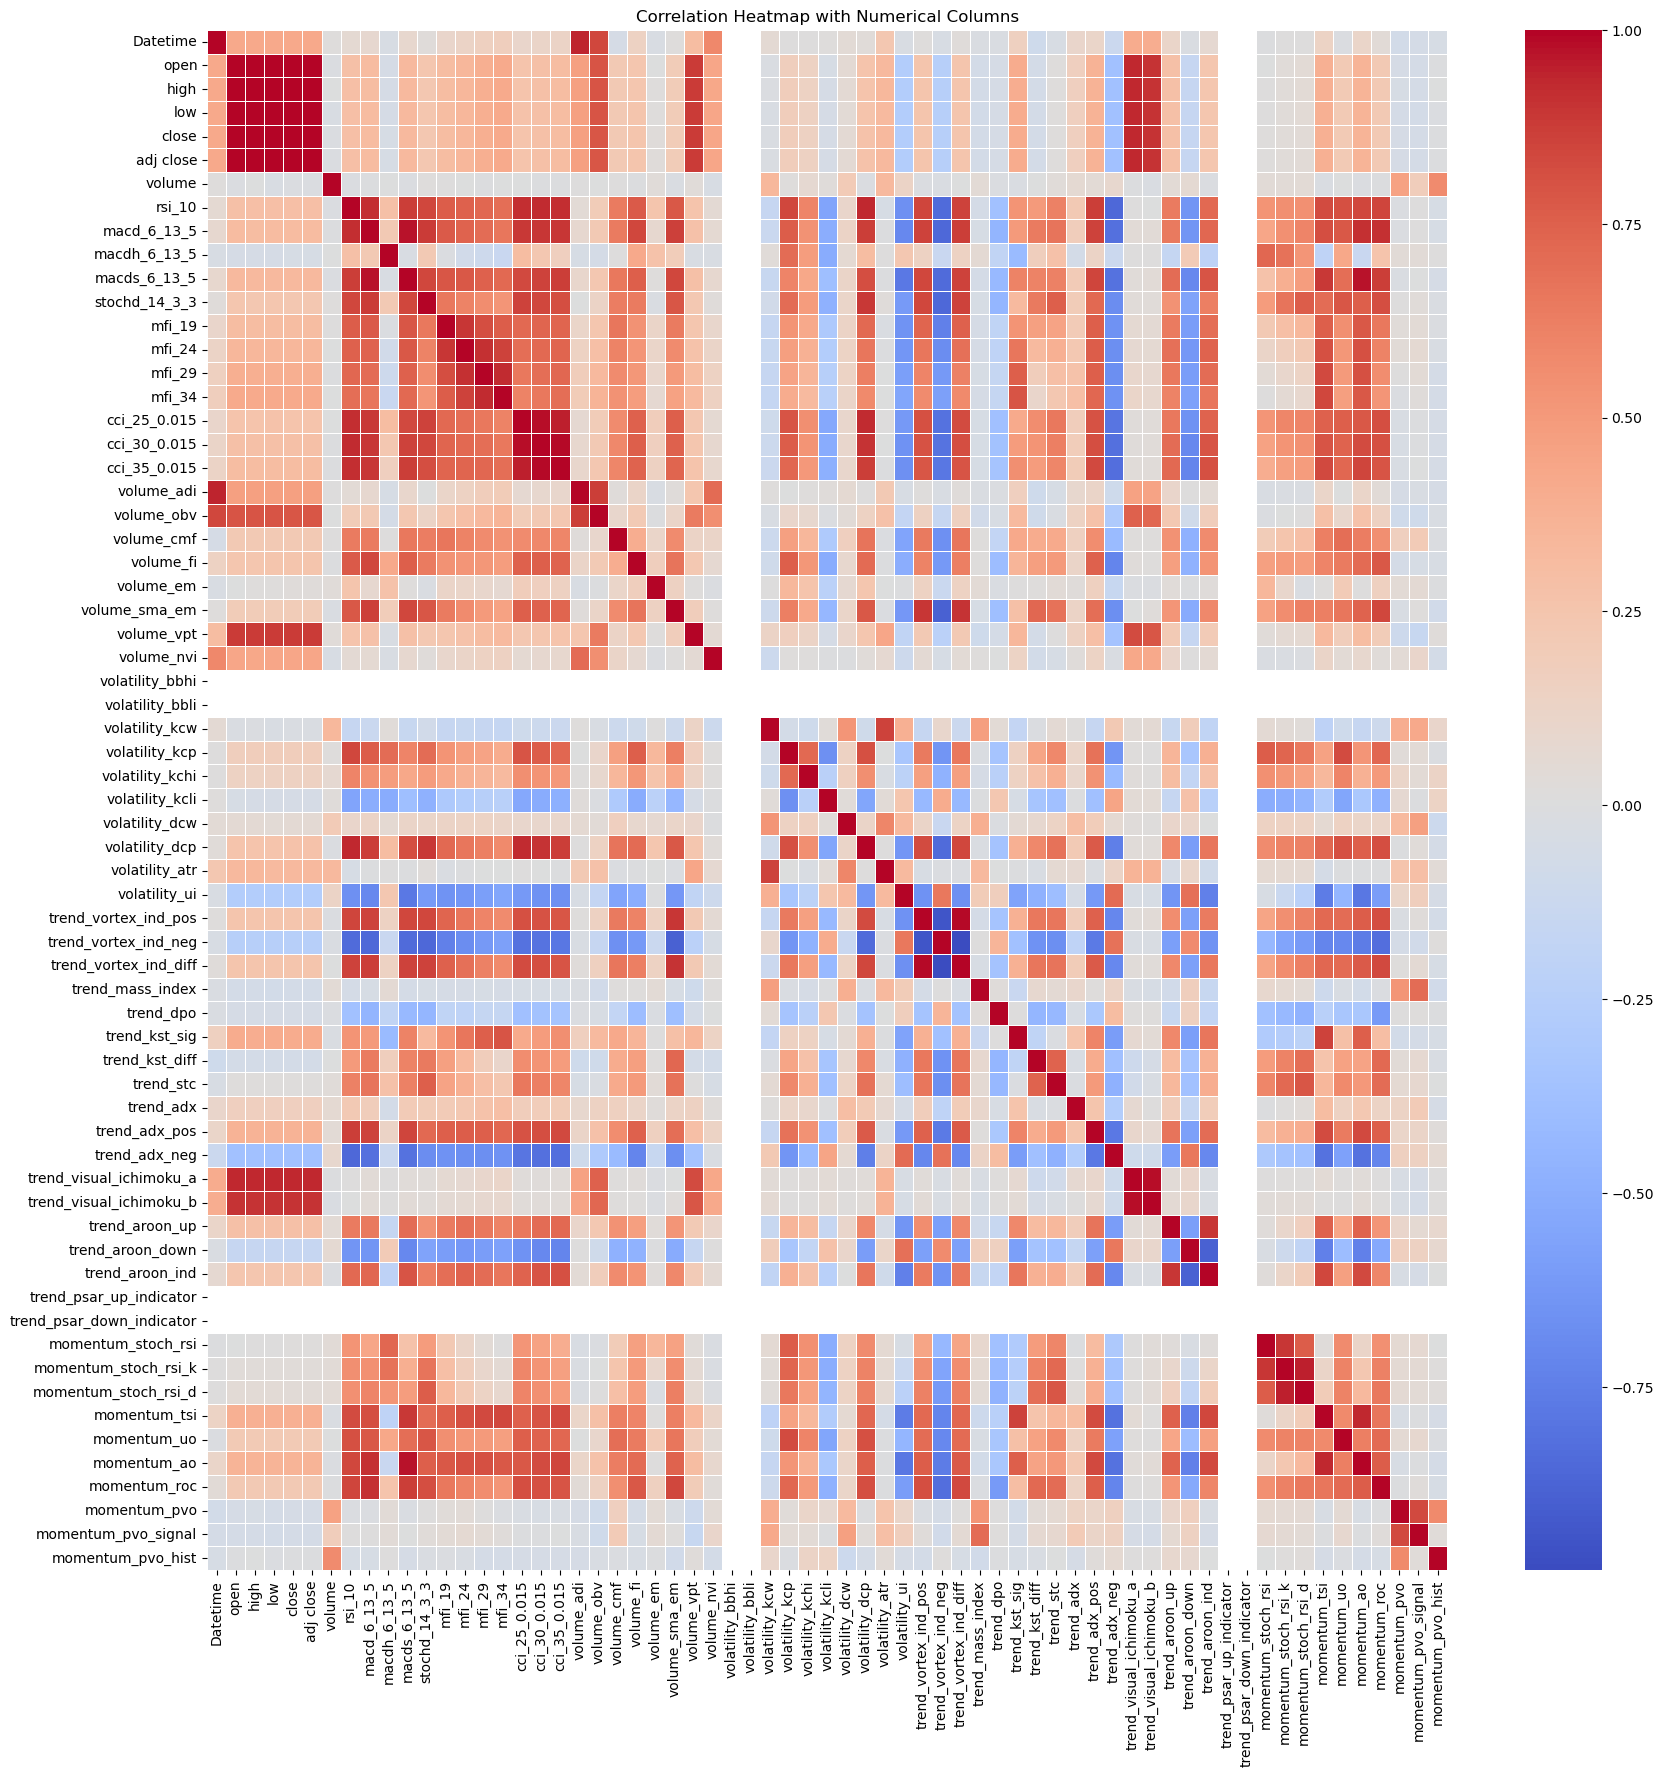

In [11]:
numerical_columns = [col for col in AAPL_cleaned.columns if col not in categorical_columns]
AAPL_numerical = AAPL_cleaned[numerical_columns]
corr = AAPL_numerical.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap with Numerical Columns')
plt.show()

The heat map below shows the correlation values between all numeric columns in the dataframe. As the color gets darker, the higher the correlation is. 

### Visualizations

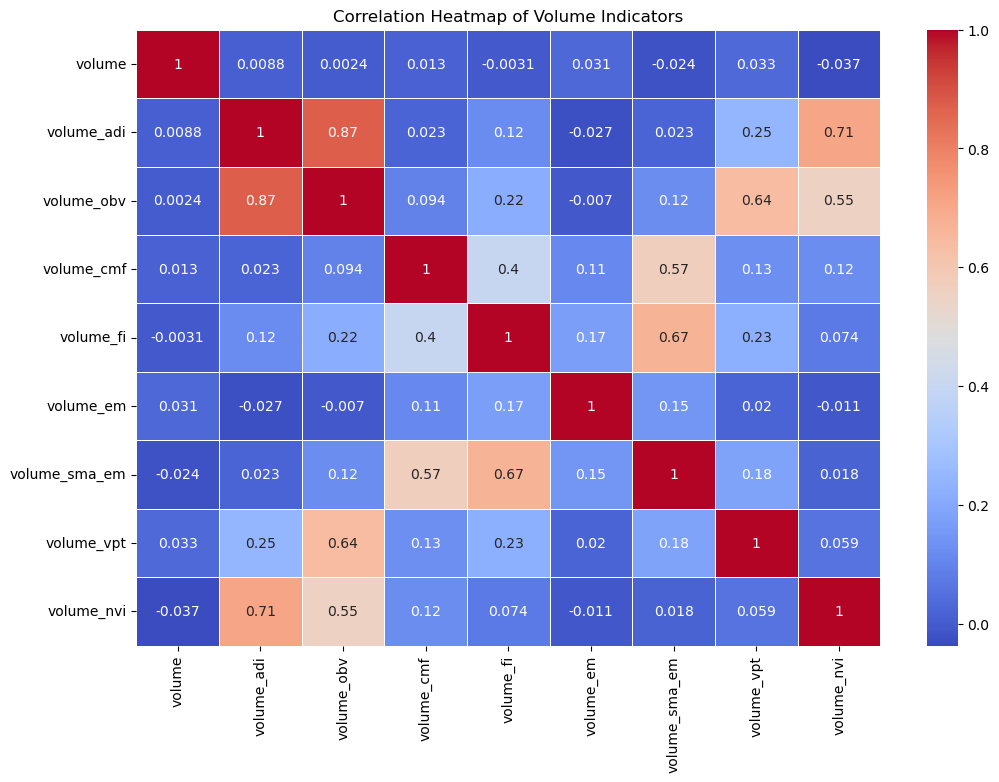

/Users/brianhonea/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


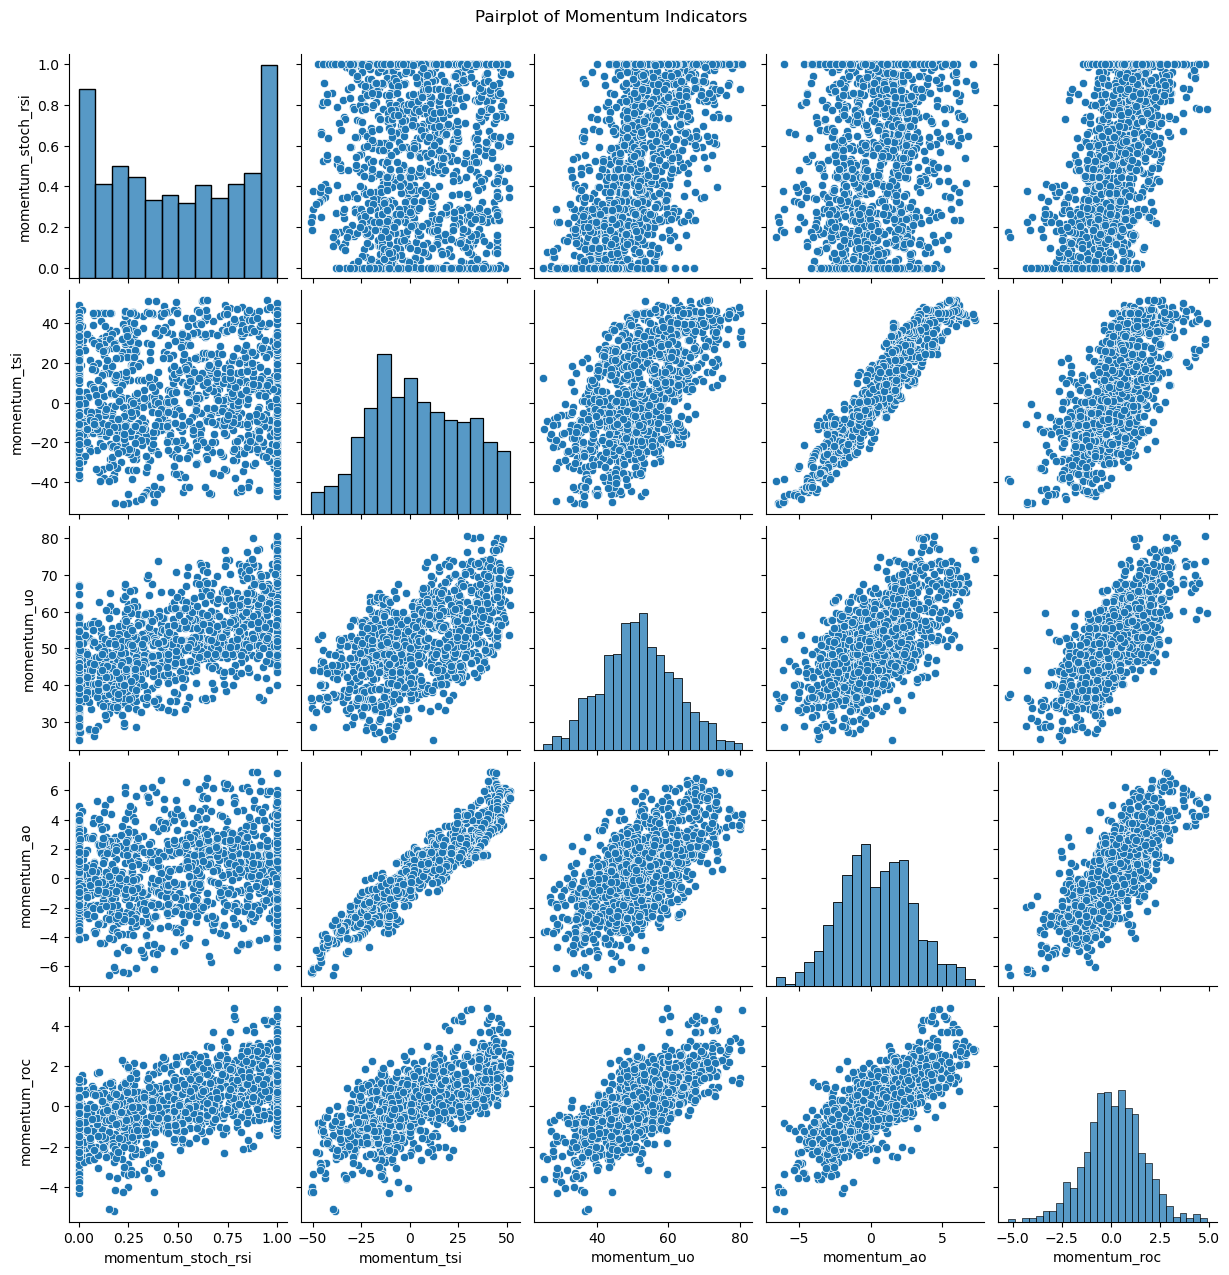

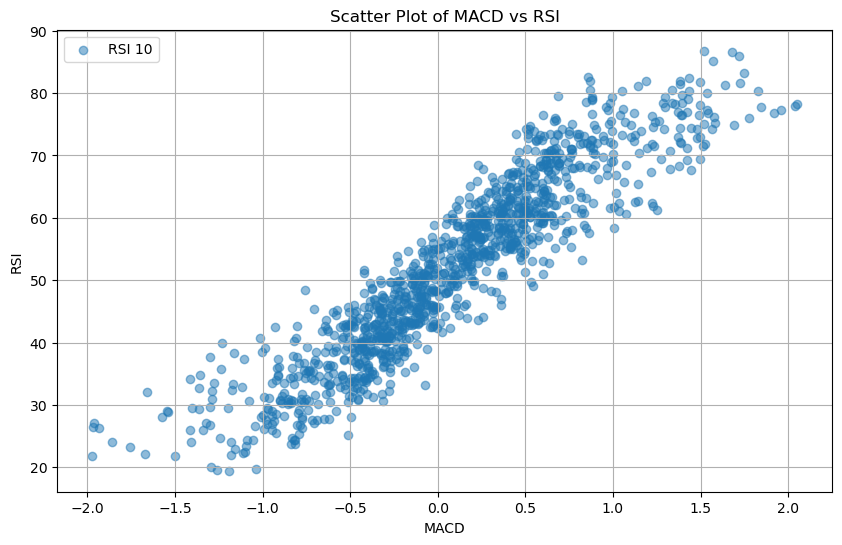

               Datetime        open        high         low       close  \
494 2023-11-14 13:30:00  187.460007  187.490005  186.820007  187.413696   
495 2023-11-14 14:30:00  187.414993  188.110001  187.414993  187.912003   
496 2023-11-14 15:30:00  187.919998  188.029999  187.210007  187.440002   
497 2023-11-15 09:30:00  187.845001  188.699997  187.800003  188.149994   
498 2023-11-15 10:30:00  188.160004  189.500000  188.110001  189.414993   

      adj close    volume      sma_10      sma_15      sma_20  ...  \
494  187.413696   4558716  186.013969  185.878386  185.474535  ...   
495  187.912003   7317327  186.348669  186.015853  185.748135  ...   
496  187.440002   6872181  186.636670  186.103853  185.931140  ...   
497  188.149994  11861855  186.952660  186.224520  186.101140  ...   
498  189.414993   8051018  187.399159  186.534446  186.324889  ...   

     momentum_pvo_signal  momentum_pvo_hist  momentum_kama  others_dr  \
494            -3.925119          -2.586101     185.216

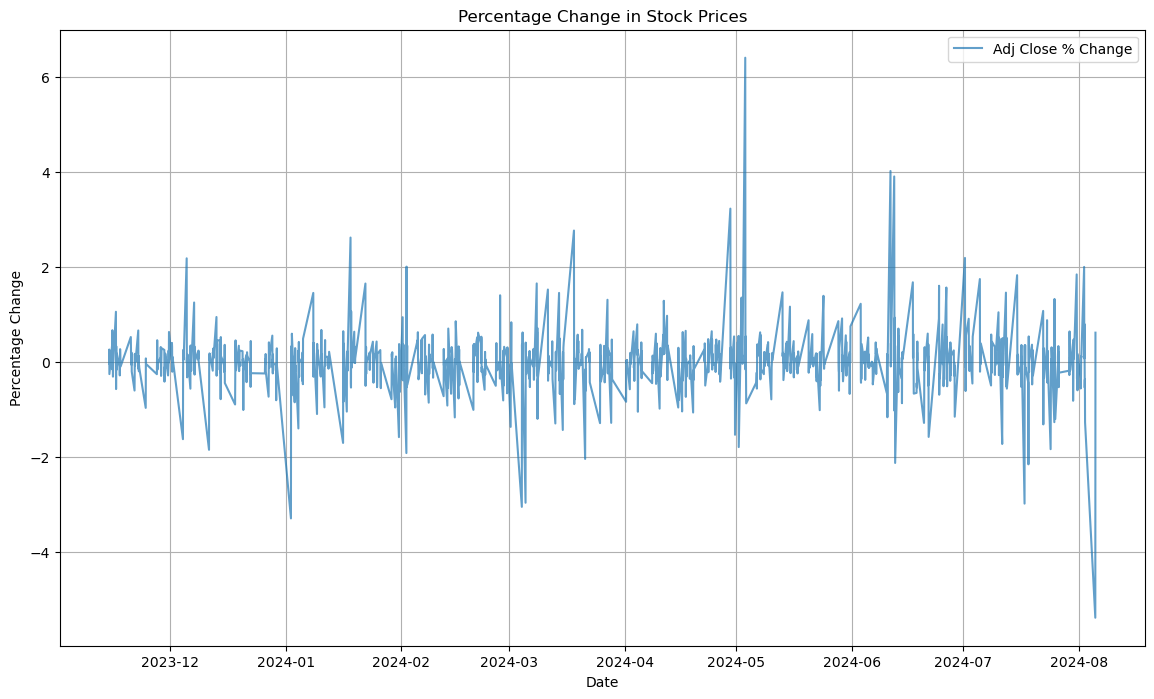

/Users/brianhonea/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


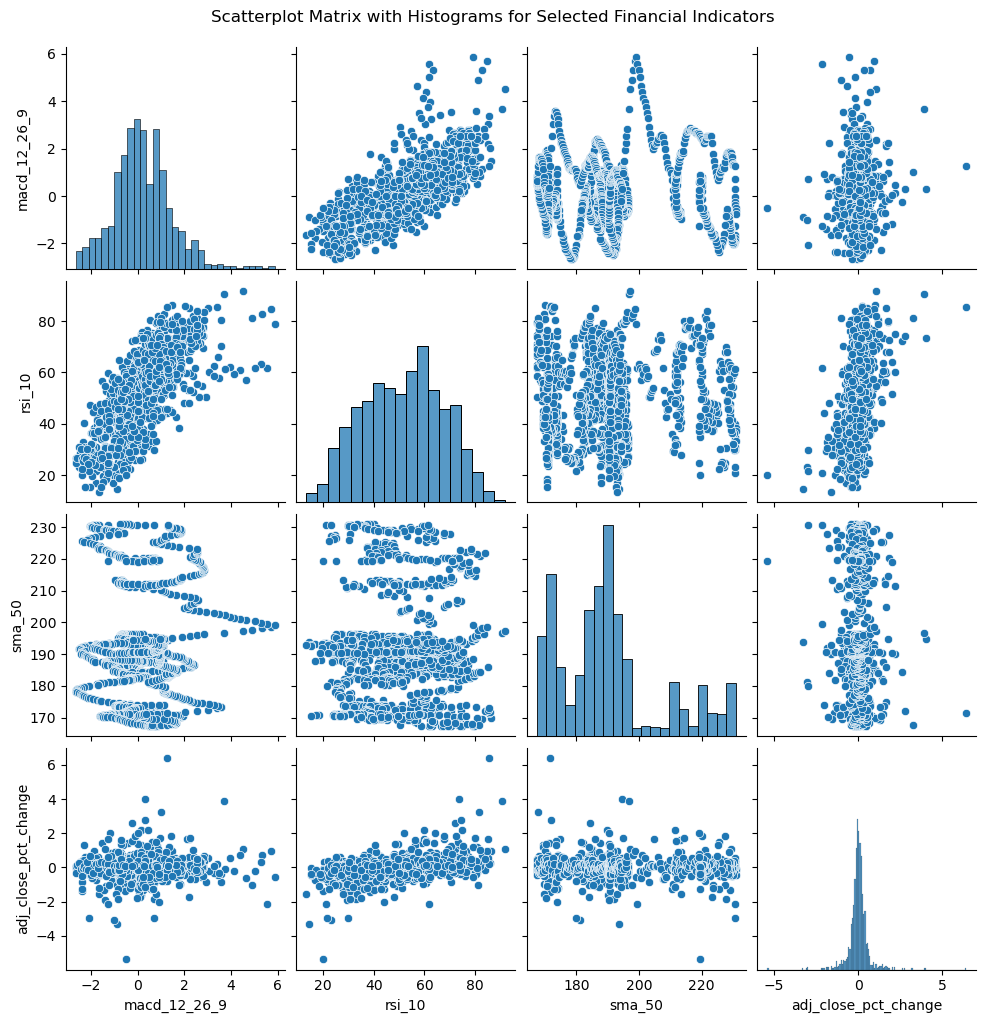

/Users/brianhonea/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


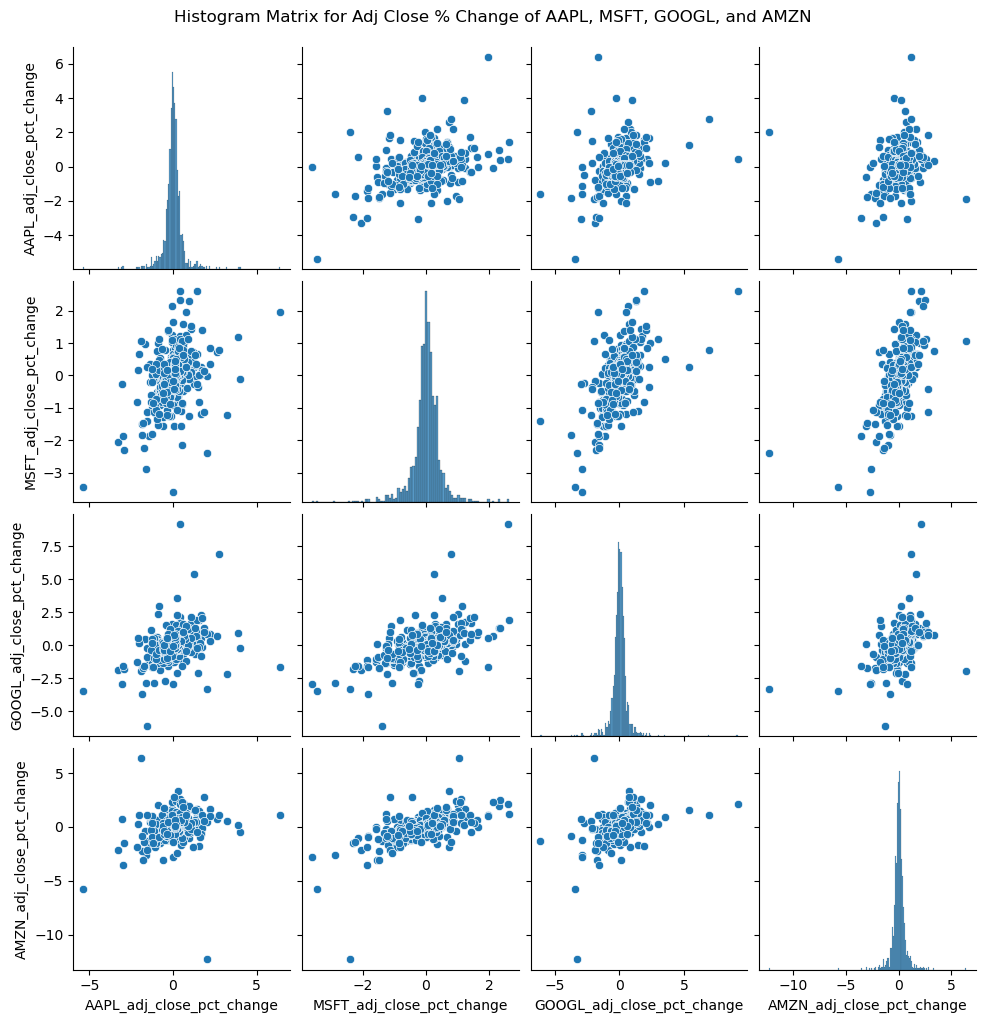

In [12]:
# Generate meaningful visualizations

# Heatmap to show correlations between different volume indicators
def plot_correlation_heatmap(df):
    plt.figure(figsize=(12, 8))
    volume_columns = ['volume', 'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 
                      'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_nvi']
    corr = df[volume_columns].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Heatmap of Volume Indicators')
    plt.show()

# Pairplot to show relationships between momentum indicators
def plot_pairplot(df):
    momentum_columns = ['momentum_stoch_rsi', 'momentum_tsi', 'momentum_uo', 
                        'momentum_ao', 'momentum_roc']
    sns.pairplot(df[momentum_columns])
    plt.suptitle('Pairplot of Momentum Indicators', y=1.02)
    plt.show()

# Scatter plot to show the relationship between MACD and RSI
def plot_scatter_macd_rsi(df):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['macd_6_13_5'], df['rsi_10'], alpha=0.5, label='RSI 10')


    plt.xlabel('MACD')
    plt.ylabel('RSI')
    plt.title('Scatter Plot of MACD vs RSI')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
# Assuming AAPL_cleaned is your DataFrame containing the data
plot_correlation_heatmap(AAPL_cleaned)
plot_pairplot(AAPL_cleaned)
plot_scatter_macd_rsi(AAPL_cleaned)


# Calculate percentage change

AAPL_data['adj_close_pct_change'] = AAPL_data['adj close'].pct_change() * 100

# Drop NaN values that were generated due to pct_change
AAPL_data.dropna(inplace=True)

# Display the updated DataFrame
print(AAPL_data.head())
import matplotlib.pyplot as plt

# Set up the plotting environment
plt.figure(figsize=(14, 8))

# Plot percentage changes

plt.plot(AAPL_data['Datetime'], AAPL_data['adj_close_pct_change'], label='Adj Close % Change', alpha=0.7)

# Add labels, legend, and title
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.title('Percentage Change in Stock Prices')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


import seaborn as sns
import matplotlib.pyplot as plt

# Assuming AAPL_data is your DataFrame

# Select the three relevant variables
selected_columns = ['macd_12_26_9', 'rsi_10', 'sma_50','adj_close_pct_change']

# Create a new DataFrame with just the selected columns
selected_data = AAPL_data[selected_columns]

# Generate the scatterplot matrix with histograms
sns.pairplot(selected_data, diag_kind='hist')

# Show the plot
plt.suptitle('Scatterplot Matrix with Histograms for Selected Financial Indicators', y=1.02)  # Adjust title position
plt.show()

# Calculate percentage change for adj close
def calculate_pct_change(df):
    df['adj_close_pct_change'] = df['adj close'].pct_change() * 100
    return df

# Apply the function to each DataFrame
MSFT_data = calculate_pct_change(MSFT_data)
GOOGL_data = calculate_pct_change(GOOGL_data)
AMZN_data = calculate_pct_change(AMZN_data)
AAPL_data = calculate_pct_change(AAPL_data)

# Combine the percentage change columns into a single DataFrame
combined_data = pd.DataFrame({
    'AAPL_adj_close_pct_change': AAPL_data['adj_close_pct_change'],
    'MSFT_adj_close_pct_change': MSFT_data['adj_close_pct_change'],
    'GOOGL_adj_close_pct_change': GOOGL_data['adj_close_pct_change'],
    'AMZN_adj_close_pct_change': AMZN_data['adj_close_pct_change']
})

# Drop rows with NaN values if they exist
combined_data = combined_data.dropna()

# Generate histogram matrix
sns.pairplot(combined_data, diag_kind='hist')

# Show the plot
plt.suptitle('Histogram Matrix for Adj Close % Change of AAPL, MSFT, GOOGL, and AMZN', y=1.02)  # Adjust title position
plt.show()



In [13]:
import yfinance as yf

recs = yf.Ticker("AAPL").recommendations.iloc[0]  # most recent recommendations (first row)
print(recs)
# print(yf.Ticker("AAPL").recommendations) # full table

# non-ratio variables
strong_buy = recs.get('strongBuy', 0)
buy = recs.get('buy', 0)
hold = recs.get('hold', 0)
sell = recs.get('sell', 0)
strong_sell = recs.get('strongSell', 0)

# function to Calculate ratios
def safe_divide(a, b):
    if a == 0 and b == 0:
        return 0
    return a / b if b != 0 else 10

# StrongBuy ratios
ratio_strong_buy_strong_sell = safe_divide(strong_buy, strong_sell)
ratio_strong_buy_sell = safe_divide(strong_buy, sell)
ratio_strong_buy_buy = safe_divide(strong_buy, buy)

# Buy ratios
ratio_buy_strong_buy = safe_divide(buy, strong_buy)
ratio_buy_strong_sell = safe_divide(buy, strong_sell)
ratio_buy_sell = safe_divide(buy, sell)

# Strong Sell ratios
ratio_strong_sell_strong_buy = safe_divide(strong_sell, strong_buy)
ratio_strong_sell_buy = safe_divide(strong_sell, buy)
ratio_strong_sell_sell = safe_divide(strong_sell, sell)

# Sell ratios
ratio_sell_strong_buy = safe_divide(sell, strong_buy)
ratio_sell_buy = safe_divide(sell, buy)
ratio_sell_strong_sell = safe_divide(sell, strong_sell)

# Ratios of total buy, sell, and hold recommendations
total_buy = strong_buy + buy
total_sell = strong_sell + sell
total_hold = hold

ratio_total_buy_to_total_sell = safe_divide(total_buy, total_sell)
ratio_total_sell_to_total_buy = safe_divide(total_sell, total_buy)
ratio_total_hold_to_total_buy = safe_divide(total_hold, total_buy)
ratio_total_hold_to_total_sell = safe_divide(total_hold, total_sell)

# Print results
print("\nCalculated Ratios")
print("BUY RATIOS:")
print(f" Strong Buy / Buy: {ratio_strong_buy_buy:.2f}")
print(f" Buy / Strong Buy: {ratio_buy_strong_buy:.2f}")

print(f" Strong Buy / Strong Sell: {ratio_strong_buy_strong_sell:.2f}")
print(f" Strong Buy / Sell: {ratio_strong_buy_sell:.2f}")

print(f" Buy / Strong Sell: {ratio_buy_strong_sell:.2f}")
print(f" Buy / Sell: {ratio_buy_sell:.2f}")

print("\nSELL RATIOS:")
print(f" Sell / Strong Sell: {ratio_sell_strong_sell:.2f}")
print(f" Strong Sell / Sell: {ratio_strong_sell_sell:.2f}")

print(f" Strong Sell / Strong Buy: {ratio_strong_sell_strong_buy:.2f}")
print(f" Strong Sell / Buy: {ratio_strong_sell_buy:.2f}")
print(f" Sell / Strong Buy: {ratio_sell_strong_buy:.2f}")
print(f" Sell / Buy: {ratio_sell_buy:.2f}")

print("\nRatios of total Recommendations:")
print(f" Total Buy recs / Total Sell recs: {ratio_total_buy_to_total_sell:.2f}")
print(f" Total Sell recs / Total Buy recs: {ratio_total_sell_to_total_buy:.2f}")
print(f" Total Hold recs / Total Buy recs: {ratio_total_hold_to_total_buy:.2f}")
print(f" Total Hold recs / Total Sell recs: {ratio_total_hold_to_total_sell:.2f}")


period        0m
strongBuy     11
buy           21
hold           6
sell           0
strongSell     0
Name: 0, dtype: object

Calculated Ratios
BUY RATIOS:
 Strong Buy / Buy: 0.52
 Buy / Strong Buy: 1.91
 Strong Buy / Strong Sell: 10.00
 Strong Buy / Sell: 10.00
 Buy / Strong Sell: 10.00
 Buy / Sell: 10.00

SELL RATIOS:
 Sell / Strong Sell: 0.00
 Strong Sell / Sell: 0.00
 Strong Sell / Strong Buy: 0.00
 Strong Sell / Buy: 0.00
 Sell / Strong Buy: 0.00
 Sell / Buy: 0.00

Ratios of total Recommendations:
 Total Buy recs / Total Sell recs: 10.00
 Total Sell recs / Total Buy recs: 0.00
 Total Hold recs / Total Buy recs: 0.19
 Total Hold recs / Total Sell recs: 10.00


### Transformation

In [14]:
# Creating new features
AAPL_cleaned['momentum_diff'] = AAPL_cleaned['momentum_tsi'] - AAPL_cleaned['momentum_uo']
AAPL_cleaned['volatility_change'] = AAPL_cleaned['volatility_atr'].diff()
AAPL_cleaned['trend_strength'] = AAPL_cleaned['trend_adx'] - AAPL_cleaned['trend_aroon_ind']



from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Select features to scale
features_to_scale = ['volume', 'rsi_10', 'macd_6_13_5', 'macdh_6_13_5',
                     'macds_6_13_5', 'stochd_14_3_3', 'mfi_19', 'momentum_diff', 
                     'volatility_change', 'trend_strength']

# Apply Standard Scaling
scaler = StandardScaler()
AAPL_cleaned[features_to_scale] = scaler.fit_transform(AAPL_cleaned[features_to_scale])




from sklearn.feature_selection import VarianceThreshold

# Apply Variance Threshold
selector = VarianceThreshold(threshold=0.1)
AAPL_selected = selector.fit_transform(AAPL_cleaned.select_dtypes(include=[np.number]))

# List of kept features
kept_features = AAPL_cleaned.columns[selector.get_support(indices=True)].tolist()

print(f"Number of features before selection: {AAPL_cleaned.shape[1]}")
print(f"Number of features after selection: {len(kept_features)}")
print(f"Kept features: {kept_features}")



Number of features before selection: 71
Number of features after selection: 56
Kept features: ['Datetime', 'open', 'high', 'low', 'close', 'adj close', 'volume', 'rsi_10', 'macd_6_13_5', 'macdh_6_13_5', 'macds_6_13_5', 'stochd_14_3_3', 'mfi_19', 'mfi_24', 'mfi_29', 'mfi_34', 'cci_25_0.015', 'cci_30_0.015', 'cci_35_0.015', 'volume_adi', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt', 'volatility_kcw', 'volatility_kcp', 'volatility_kchi', 'volatility_kcli', 'volatility_atr', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_mass_index', 'trend_dpo', 'trend_kst_sig', 'trend_kst_diff', 'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up', 'trend_aroon_down', 'trend_psar_down_indicator', 'momentum_stoch_rsi', 'momentum_stoch_rsi_d', 'momentum_tsi', 'momentum_uo', 'momentum_ao', 'momentum_roc', 'momentum_pvo', 'momentum_pvo_signal', 'momentum_pvo_hist', 'trend', 'momentum']


In [15]:

# Define binning thresholds and labels for each column
discretization_config = {
    'volume': {
        'bins': [-np.inf, 0.33, 0.66, np.inf],
        'labels': ['Low', 'Medium', 'High']
    },
    'rsi_10': {
        'bins': [0, 30, 70, 100],
        'labels': ['Oversold', 'Neutral', 'Overbought']
    },
    'rsi_20': {
        'bins': [0, 30, 70, 100],
        'labels': ['Oversold', 'Neutral', 'Overbought']
    },
    'macd_6_13_5': {
        'bins': 3,
        'labels': ['Low', 'Medium', 'High']
    },
    'stochd_14_3_3': {
        'bins': [0, 20, 80, 100],
        'labels': ['Oversold', 'Neutral', 'Overbought']
    },
    'mfi_19': {
        'bins': [0, 30, 70, 100],
        'labels': ['Low', 'Neutral', 'High']
    },
    'volume_adi': {
        'bins': 3,
        'labels': ['Low', 'Medium', 'High']
    },
    'volume_obv': {
        'bins': 3,
        'labels': ['Low', 'Medium', 'High']
    },
    'volume_cmf': {
        'bins': 3,
        'labels': ['Low', 'Medium', 'High']
    },
    'volume_fi': {
        'bins': 3,
        'labels': ['Low', 'Medium', 'High']
    },
    'volume_em': {
        'bins': 3,
        'labels': ['Low', 'Medium', 'High']
    },
    'volume_sma_em': {
        'bins': 3,
        'labels': ['Low', 'Medium', 'High']
    },
    'volume_vpt': {
        'bins': 3,
        'labels': ['Low', 'Medium', 'High']
    },
    'volume_nvi': {
        'bins': 3,
        'labels': ['Low', 'Medium', 'High']
    },
    'volatility_bbhi': {
        'bins': 3,
        'labels': ['Low', 'Medium', 'High']
    },
    'volatility_bbli': {
        'bins': 3,
        'labels': ['Low', 'Medium', 'High']
    },
    'volatility_kcw': {
        'bins': 3,
        'labels': ['Low', 'Medium', 'High']
    },
    'volatility_kcp': {
        'bins': 3,
        'labels': ['Low', 'Medium', 'High']
    },
    'volatility_kchi': {
        'bins': 3,
        'labels': ['Low', 'Medium', 'High']
    },
    'volatility_kcli': {
        'bins': 3,
        'labels': ['Low', 'Medium', 'High']
    },
    'volatility_dcw': {
        'bins': 3,
        'labels': ['Low', 'Medium', 'High']
    },
    'volatility_dcp': {
        'bins': 3,
        'labels': ['Low', 'Medium', 'High']
    },
    'volatility_atr': {
        'bins': 3,
        'labels': ['Low', 'Medium', 'High']
    },
    'volatility_ui': {
        'bins': 3,
        'labels': ['Low', 'Medium', 'High']
    },
    'trend_vortex_ind_pos': {
        'bins': 3,
        'labels': ['Low', 'Medium', 'High']
    },
    'trend_mass_index': {
        'bins': 3,
        'labels': ['Low', 'Medium', 'High']
    },
    'trend_adx': {
        'bins': [0, 20, 40, 100],
        'labels': ['Weak', 'Moderate', 'Strong']
    },
    'momentum_stoch_rsi': {
        'bins': 3,
        'labels': ['Low', 'Medium', 'High']
    },
    'momentum_roc': {
        'bins': 3,
        'labels': ['Low', 'Medium', 'High']
    }
}

# Apply discretization
for col, config in discretization_config.items():
    if col in AAPL_cleaned.columns:
        AAPL_cleaned[f'{col}_bin'] = pd.cut(AAPL_cleaned[col], bins=config['bins'], labels=config['labels'])

print(AAPL_cleaned.head())


print(f"Number of features before binning: {AAPL_cleaned.shape[1] - 1}")
print(f"Number of features after binning: {AAPL_cleaned.shape[1]}")

              Datetime        open        high         low       close  \
37 2023-08-14 11:30:00  179.350006  179.488007  178.619995  178.714493   
38 2023-08-14 12:30:00  178.710007  179.440002  178.589996  179.227905   
39 2023-08-14 13:30:00  179.229996  179.350006  178.909607  179.089996   
42 2023-08-15 09:30:00  178.880005  179.479996  177.529999  177.811905   
43 2023-08-15 10:30:00  177.815002  178.229996  177.380005  178.149902   

     adj close    volume    rsi_10  macd_6_13_5  macdh_6_13_5  ...  \
37  178.714493 -0.532417  0.080082     0.076109      0.816714  ...   
38  179.227905 -1.109454  0.408344     0.199557      0.891929  ...   
39  179.089996 -0.853996  0.290336     0.231850      0.694465  ...   
42  177.811905  2.547487 -0.678907    -0.028832     -0.524971  ...   
43  178.149902 -0.153643 -0.432230    -0.161409     -0.697968  ...   

    volatility_kcli_bin  volatility_dcw_bin  volatility_dcp_bin  \
37                  Low                 Low              Medium   


Skewness of variables:
 open                     0.759456
high                     0.766887
low                      0.747322
close                    0.753624
adj close                0.753624
                           ...   
trend_psar_down          0.809518
momentum_rsi            -0.031995
momentum_uo              0.090612
momentum_stoch_signal   -0.052956
momentum_kama            0.782286
Length: 435, dtype: float64

Variables with high skewness:
 bbb_20_2.0        2.671260
bbb_20_3.0        2.671260
bbb_25_2.0        2.394916
bbb_25_3.0        2.394916
volatility_bbw    2.671260
volatility_dcw    2.446144
dtype: float64


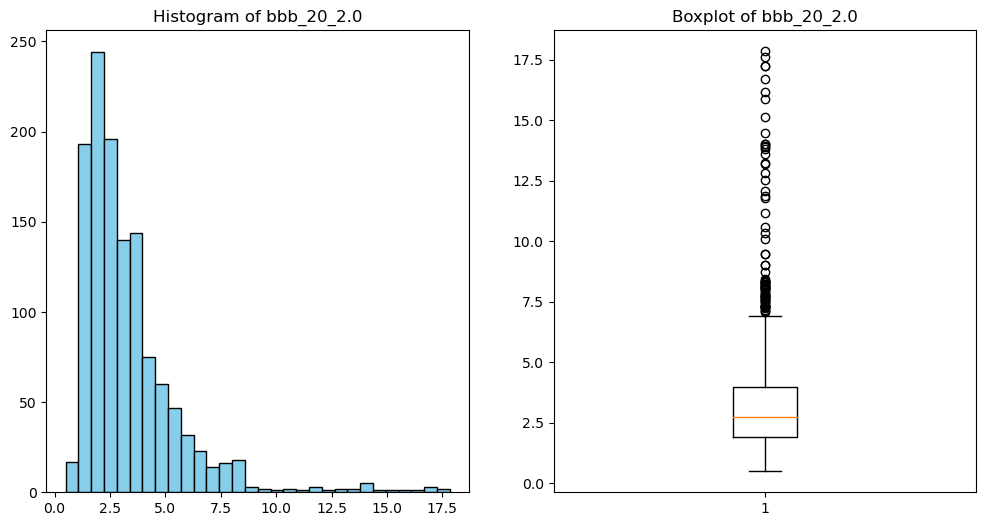

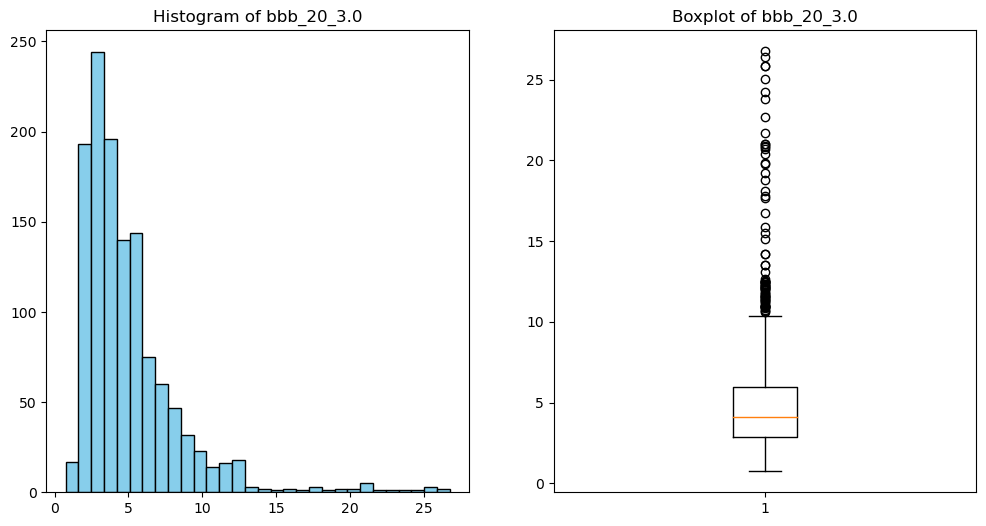

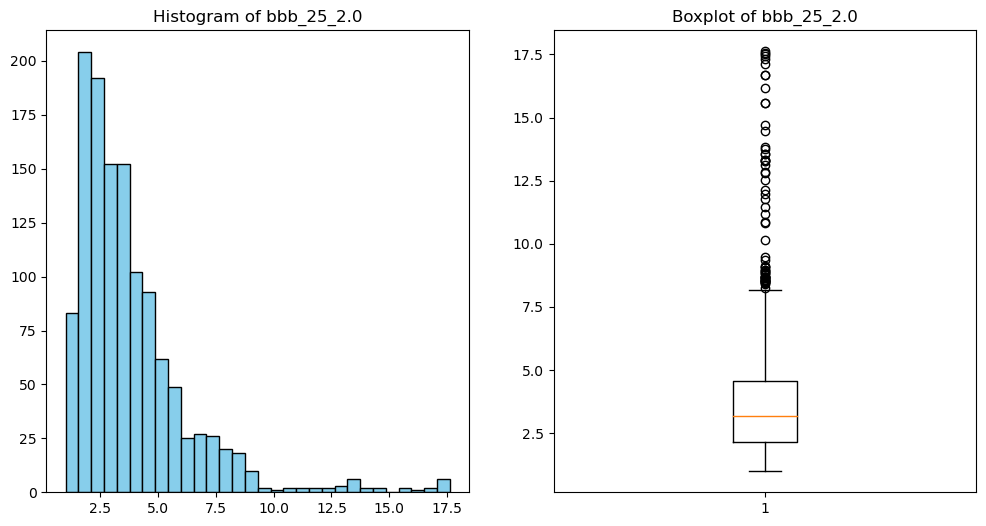

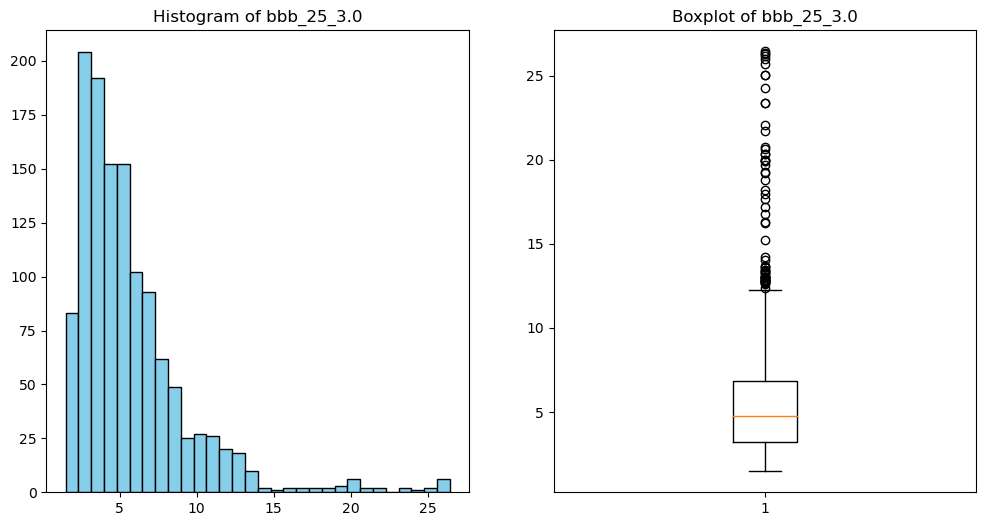

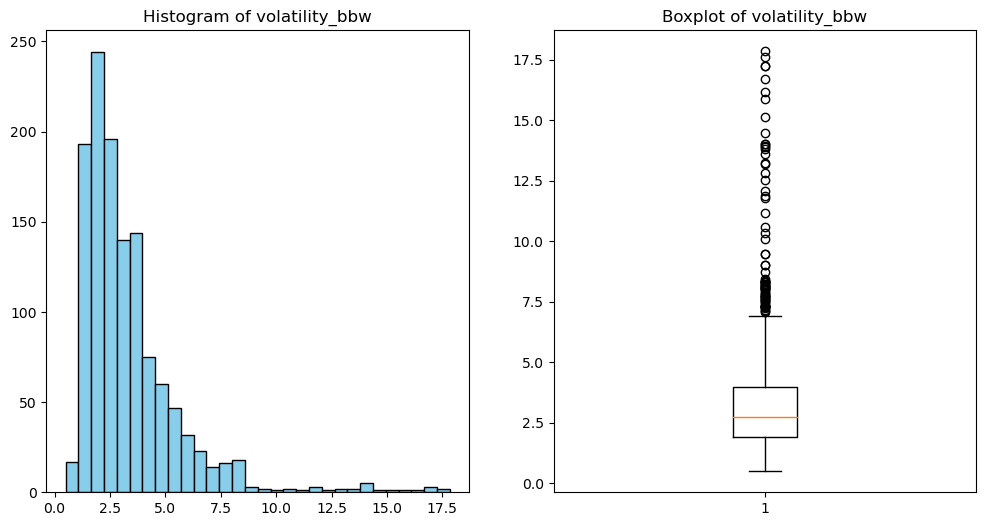

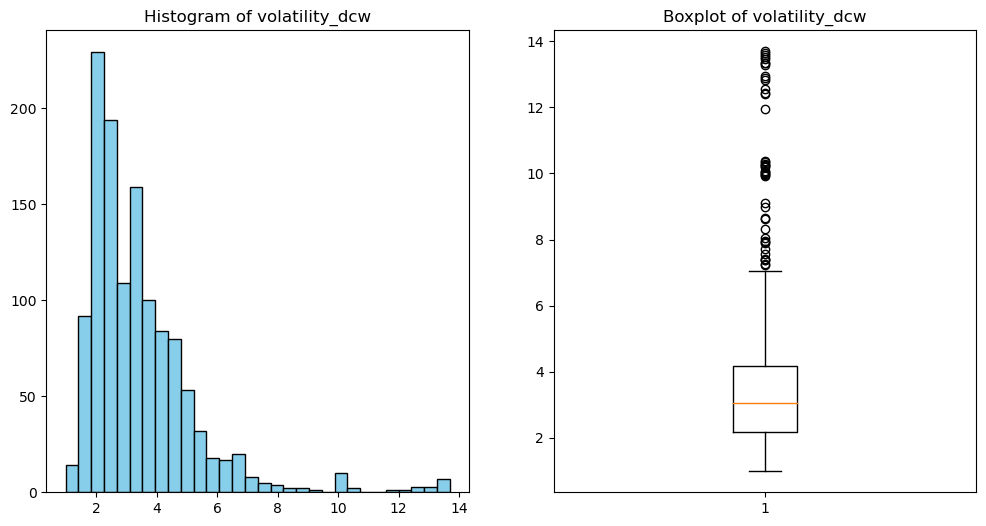


Data after log transformation:
                Datetime        open        high         low       close  \
494 2023-11-14 13:30:00  187.460007  187.490005  186.820007  187.413696   
495 2023-11-14 14:30:00  187.414993  188.110001  187.414993  187.912003   
496 2023-11-14 15:30:00  187.919998  188.029999  187.210007  187.440002   
497 2023-11-15 09:30:00  187.845001  188.699997  187.800003  188.149994   
498 2023-11-15 10:30:00  188.160004  189.500000  188.110001  189.414993   

      adj close    volume      sma_10      sma_15      sma_20  ...  \
494  187.413696   4558716  186.013969  185.878386  185.474535  ...   
495  187.912003   7317327  186.348669  186.015853  185.748135  ...   
496  187.440002   6872181  186.636670  186.103853  185.931140  ...   
497  188.149994  11861855  186.952660  186.224520  186.101140  ...   
498  189.414993   8051018  187.399159  186.534446  186.324889  ...   

     momentum_pvo_signal  momentum_pvo_hist  momentum_kama  others_dr  \
494            -3.9251

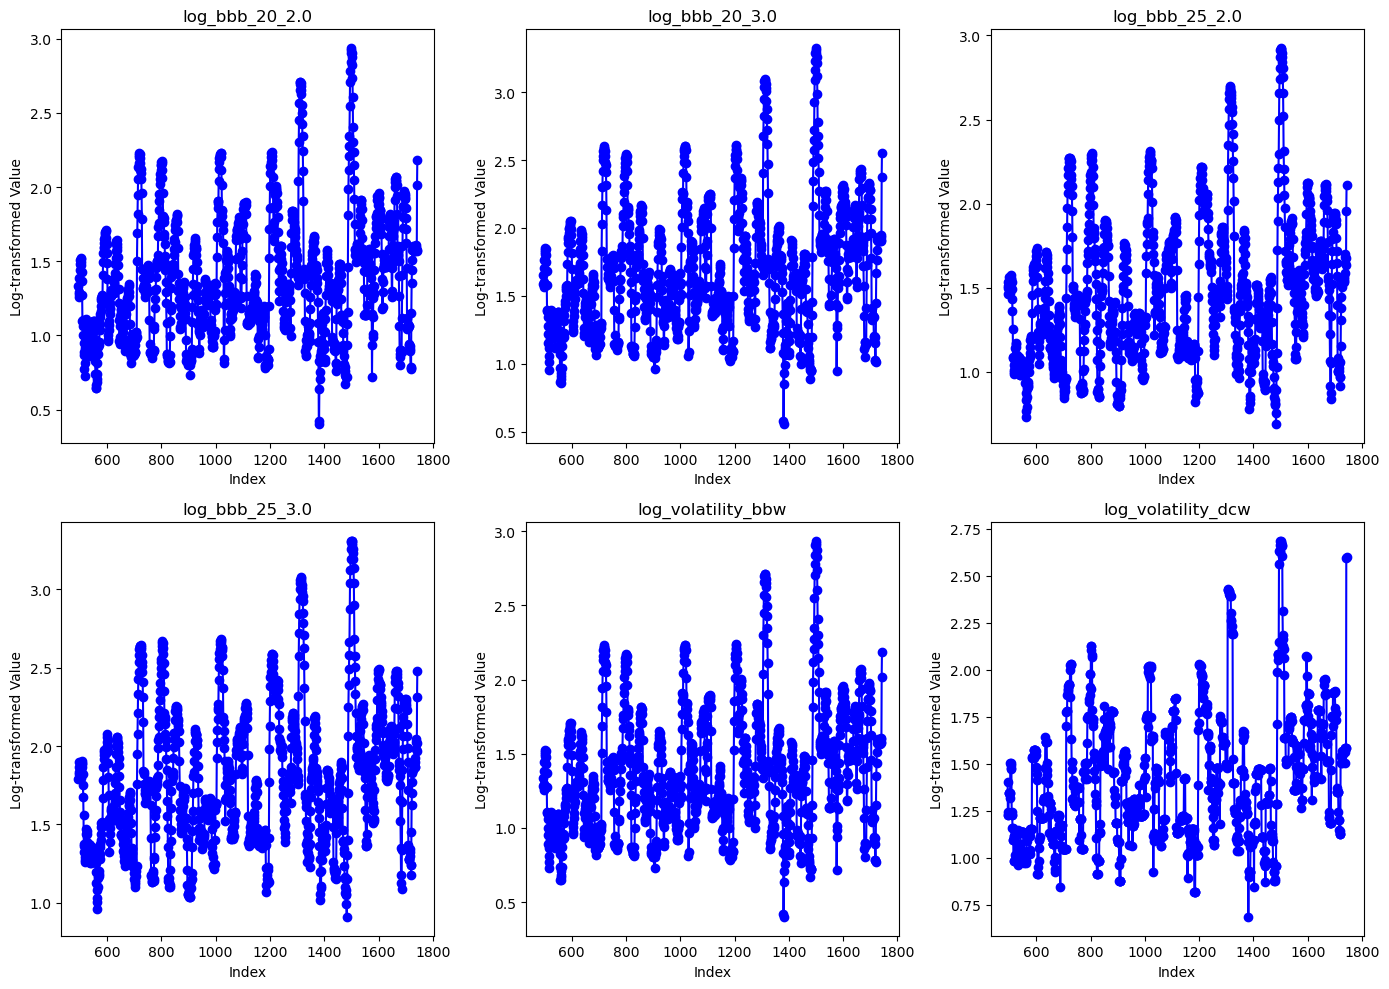

In [16]:

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Select only numerical columns for analysis
numerical_data = AAPL_data.select_dtypes(include=[np.number])

# Check which columns have non-positive values
positive_columns = (numerical_data > 0).all()

# Filter out columns with non-positive values
positive_data = numerical_data.loc[:, positive_columns]

# Calculate skewness
skewness = positive_data.apply(lambda x: stats.skew(x.dropna()))
print("Skewness of variables:\n", skewness)

# Identify variables with high skewness (e.g., absolute skewness > 2)
high_skew = skewness[abs(skewness) > 2]
print("\nVariables with high skewness:\n", high_skew)

# Plot histograms and box plots for variables with high skewness
for column in high_skew.index:
    plt.figure(figsize=(12, 6))
    
    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(AAPL_data[column].dropna(), bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column}')
    
    # Boxplot
    plt.subplot(1, 2, 2)
    plt.boxplot(AAPL_data[column].dropna())
    plt.title(f'Boxplot of {column}')
    
    plt.show()



# Optionally, apply log transformation to variables with high skewness
log_transformed_data = AAPL_data.copy()
for column in high_skew.index:
    log_transformed_data[column] = np.log1p(AAPL_data[column])

print("\nData after log transformation:\n", log_transformed_data.head())
# Define the variables to be log-transformed
variables_to_transform = [
    'bbb_20_2.0',
    'bbb_20_3.0',
    'bbb_25_2.0',
    'bbb_25_3.0',
    'volatility_bbw',
    'volatility_dcw'
]

# Apply log transformation
for variable in variables_to_transform:
    # Ensure the variable exists in the DataFrame
    if variable in AAPL_data.columns:
        # Apply log transformation
        AAPL_data[f'log_{variable}'] = np.log1p(AAPL_data[variable])
        # Drop the original variable
        AAPL_data.drop(columns=[variable], inplace=True)
    else:
        print(f"Variable '{variable}' not found in DataFrame.")

# Plot the log-transformed variables
plt.figure(figsize=(14, 10))

# List of log-transformed columns to plot
log_transformed_columns = [f'log_{var}' for var in variables_to_transform]

for i, variable in enumerate(log_transformed_columns):
    plt.subplot(2, 3, i+1)  # Arrange plots in a 2x3 grid
    plt.plot(AAPL_data[variable], marker='o', linestyle='-', color='b')
    plt.title(variable)
    plt.xlabel('Index')
    plt.ylabel('Log-transformed Value')

plt.tight_layout()
plt.show()


In [19]:
# Save the cleaned DataFrame to an Excel file
output_file = 'AAPL_cleaned.csv'
AAPL_cleaned.to_csv(output_file, index=False)